<a href="https://colab.research.google.com/github/SriVinayA/SJSU-CMPE258-DeepLearning/blob/main/part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Images

## Step 1: Extract the Dataset

In [ ]:
import zipfile
import os

# Path to the uploaded zip file and extraction target directory
zip_path = '/content/cats_and_dogs_filtered.zip'
extraction_path = '/content/cats_and_dogs_filtered'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Check the contents of the extracted directory
os.listdir(extraction_path)

['cats_and_dogs_filtered']

## Step 2: Prepare the Training and Validation Datasets

In [ ]:
import tensorflow as tf

# Define constants
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
dataset_path = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered'

# Set up training and validation directories
train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')

# Create training and validation datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## Step 3: Set Up the Transfer Learning Model


In [ ]:
# Load the pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Create a new model on top of the output of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
63/63 [==============================] - 49s 707ms/step - loss: 0.6946 - accuracy: 0.5580 - val_loss: 0.6612 - val_accuracy: 0.6080
Epoch 2/10
63/63 [==============================] - 32s 508ms/step - loss: 0.6321 - accuracy: 0.6440 - val_loss: 0.6491 - val_accuracy: 0.6270
Epoch 3/10
63/63 [==============================] - 44s 701ms/step - loss: 0.6131 - accuracy: 0.6600 - val_loss: 0.6447 - val_accuracy: 0.6330
Epoch 4/10
63/63 [==============================] - 42s 672ms/step - loss: 0.5983 - accuracy: 0.6715 - val_loss: 0.6360 - val_accuracy: 0.6400
Epoch 5/10
63/63 [==============================] - 41s 660ms/step - loss: 0.5895 - accuracy: 0.6870 - val_loss: 0.6341 - val_accuracy: 0.6420
Epoch 6/10
63/63 [==============================] - 45s 716ms/step - loss: 0.5781 - accuracy: 0.6950 - val_loss: 0.6308 - val_accuracy: 0.6500
Epoch 7/10
63/63 [==============================] - 41s 647ms/step - loss: 0.57

## Step 4: Fine-Tuning

In [ ]:
# Unfreeze the base_model and set the bottom layers to be untrainable
base_model.trainable = True

# Freeze all layers except for the last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model (necessary for these changes to take effect) with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Continue training
fine_tune_epochs = 10
total_epochs = 10 + fine_tune_epochs  # previous + fine-tune epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 44s 633ms/step - loss: 1.1232 - accuracy: 0.5590 - val_loss: 0.8164 - val_accuracy: 0.5670
Epoch 11/20
63/63 [==============================] - 48s 772ms/step - loss: 0.8630 - accuracy: 0.6130 - val_loss: 0.9722 - val_accuracy: 0.5260
Epoch 12/20
63/63 [==============================] - 41s 649ms/step - loss: 0.7145 - accuracy: 0.6520 - val_loss: 1.0346 - val_accuracy: 0.5160
Epoch 13/20
63/63 [==============================] - 49s 787ms/step - loss: 0.6211 - accuracy: 0.6900 - val_loss: 1.0293 - val_accuracy: 0.5180
Epoch 14/20
63/63 [==============================] - 49s 791ms/step - loss: 0.5614 - accuracy: 0.7105 - val_loss: 0.9988 - val_accuracy: 0.5220
Epoch 15/20
63/63 [==============================] - 49s 779ms/step - loss: 0.5213 - accuracy: 0.7360 - val_loss: 0.9473 - val_accuracy: 0.5310
Epoch 16/20
63/63 [==============================] - 50s 795ms/step - loss: 0.4914 - accuracy: 0.7570 - val_loss: 0.9059 - val_accuracy:

## Step 5: Plot Training & Validation Accuracy and Loss Values


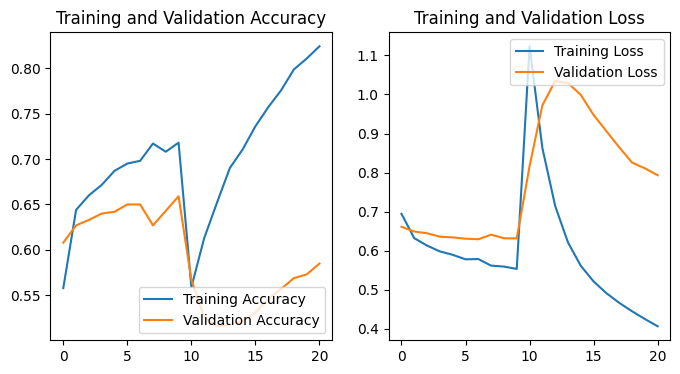

In [ ]:
import matplotlib.pyplot as plt

# Combine the history of the initial training and fine-tuning
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Make sure epochs range is set to the total number of epochs
epochs_range = range(len(acc))

# Plot training and validation accuracy
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Video

In [14]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [15]:
#@title Import the necessary modules
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

In [16]:
#@title Helper functions for the UCF101 dataset

# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetches a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, duration=40)
  return embed.embed_file('./animation.gif')

In [17]:
#@title Get the kinetics-400 labels
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


# Using the UCF101 dataset

In [18]:
# Get the list of videos in the dataset.
ucf_videos = list_ucf_videos()

categories = {}
for video in ucf_videos:
  category = video[2:-12]
  if category not in categories:
    categories[category] = []
  categories[category].append(video)
print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))


Found 13320 videos in 101 categories.
ApplyEyeMakeup        145 videos (v_ApplyEyeMakeup_g01_c01.avi, v_ApplyEyeMakeup_g01_c02.avi, ...)
ApplyLipstick         114 videos (v_ApplyLipstick_g01_c01.avi, v_ApplyLipstick_g01_c02.avi, ...)
Archery               145 videos (v_Archery_g01_c01.avi, v_Archery_g01_c02.avi, ...)
BabyCrawling          132 videos (v_BabyCrawling_g01_c01.avi, v_BabyCrawling_g01_c02.avi, ...)
BalanceBeam           108 videos (v_BalanceBeam_g01_c01.avi, v_BalanceBeam_g01_c02.avi, ...)
BandMarching          155 videos (v_BandMarching_g01_c01.avi, v_BandMarching_g01_c02.avi, ...)
BaseballPitch         150 videos (v_BaseballPitch_g01_c01.avi, v_BaseballPitch_g01_c02.avi, ...)
BasketballDunk        131 videos (v_BasketballDunk_g01_c01.avi, v_BasketballDunk_g01_c02.avi, ...)
Basketball            134 videos (v_Basketball_g01_c01.avi, v_Basketball_g01_c02.avi, ...)
BenchPress            160 videos (v_BenchPress_g01_c01.avi, v_BenchPress_g01_c02.avi, ...)
Biking              

In [19]:
# Get a sample cricket video.
video_path = fetch_ucf_video("v_CricketShot_g04_c02.avi")
sample_video = load_video(video_path)

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_CricketShot_g04_c02.avi => /tmp/tmp9u1s21on/v_CricketShot_g04_c02.avi


In [20]:
sample_video.shape

(116, 224, 224, 3)

In [21]:
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

Run the id3 model and print the top-5 action predictions.

In [22]:
def predict(sample_video):
  # Add a batch axis to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:5]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

In [23]:
predict(sample_video)

Top 5 actions:
  playing cricket       : 97.77%
  skateboarding         :  0.71%
  robot dancing         :  0.56%
  roller skating        :  0.56%
  golf putting          :  0.13%
